# Import dataset from Kaggle and read

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"akshalaniche","key":"2c01262083914425887e3dc862c4aaa0"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [5]:
!ls -l ~/.kaggle
!cat ~/.kaggle/kaggle.json
!pip install -q kaggle
!pip install -q kaggle-cli

total 4
-rw------- 1 root root 68 Mar 16 22:01 kaggle.json
    100% |████████████████████████████████| 81kB 3.2MB/s 
    100% |████████████████████████████████| 5.3MB 6.2MB/s 
    100% |████████████████████████████████| 92kB 26.0MB/s 
    100% |████████████████████████████████| 51kB 19.1MB/s 


In [6]:
!kaggle competitions download -c comp-551-w2019-project-3-modified-mnist

  0% 0.00/302k [00:00<?, ?B/s]
100% 302k/302k [00:00<00:00, 46.1MB/s]
 63% 28.0M/44.1M [00:00<00:00, 91.2MB/s]
100% 44.1M/44.1M [00:00<00:00, 145MB/s] 
 93% 164M/177M [00:01<00:00, 157MB/s]
100% 177M/177M [00:01<00:00, 148MB/s]
  0% 0.00/67.3k [00:00<?, ?B/s]
100% 67.3k/67.3k [00:00<00:00, 59.2MB/s]


In [7]:
!ls -l --block-size=M

total 222M
-rw-r--r-- 1 root root   1M Mar 16 22:00 kaggle.json
drwxr-xr-x 1 root root   1M Mar  8 17:26 sample_data
-rw-r--r-- 1 root root   1M Mar 16 22:01 sample_submission.csv
-rw-r--r-- 1 root root  45M Mar 16 22:01 test_images.pkl.zip
-rw-r--r-- 1 root root 177M Mar 16 22:01 train_images.pkl.zip
-rw-r--r-- 1 root root   1M Mar 16 22:01 train_labels.csv


In [8]:
!unzip train_images.pkl.zip
!unzip test_images.pkl.zip

Archive:  train_images.pkl.zip
  inflating: train_images.pkl        
Archive:  test_images.pkl.zip
  inflating: test_images.pkl         


In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [0]:
#Files are stored in pickle format.
#Load them like how you load any pickle. The data is a numpy array
import pandas as pd
import pickle

infile = open('./train_images.pkl','rb')
train_images = pickle.load(infile)

infile = open('./test_images.pkl','rb')
test_images = pickle.load(infile)


#train_images = pd.read_pickle('../input/train_images.pkl')
train_labels = pd.read_csv('train_labels.csv')

In [10]:
train_images.shape

(40000, 64, 64)

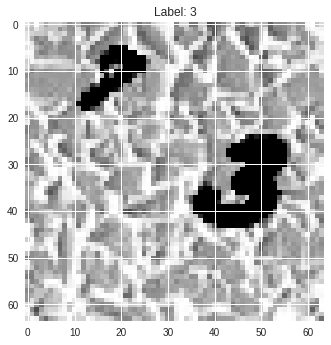

[[ 50.  79.   0. ...   0.  88.  62.]
 [ 74.  98.  46. ...  11.  18.  26.]
 [ 51.  71.  82. ...  52.  15.   5.]
 ...
 [ 12. 136. 195. ... 175. 113.   3.]
 [ 29.  91. 168. ... 117.  65.  87.]
 [ 65.   9.  29. ...   6. 104. 164.]]


In [12]:
import matplotlib.pyplot as plt

#Let's show image with id 16
img_idx = 200

plt.title('Label: {}'.format(train_labels.iloc[img_idx]['Category']))
plt.imshow(train_images[img_idx])
plt.show()

print(train_images[img_idx])

# Imports

In [0]:
import csv

import matplotlib.patches as mpatches

from skimage.morphology import label, closing, square
from skimage.measure import regionprops
from skimage.color import label2rgb
from skimage.transform import resize, rotate
from skimage.color import rgb2gray
from skimage import data
from skimage.filters import threshold_otsu, threshold_local
from skimage.segmentation import clear_border

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, MaxPool2D
from keras.layers.advanced_activations import LeakyReLU 
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.callbacks import ReduceLROnPlateau
from keras import regularizers, initializers

import cv2

# Preprocessing

In [0]:
#Set constants
batch_size = 128
num_classes = 10
epochs = 12
seed = 7
np.random.seed(seed)
img_rows, img_cols = 28, 28
number_of_classes = 10


In [0]:
def preprocess(x, imgDim):
    finalData = np.zeros(shape=(x.shape[0], imgDim, imgDim))
    finImgs = np.zeros(shape=(x.shape[0] * 4, imgDim, imgDim))
    finLabels = []
    #Loop through every image in provided data
    for n in range(x.shape[0]):

        #Binarizing the image
        currImg = np.array(x[n])
        currImg[currImg != 255] = 0 #Non-black pixel--> threshold as a 0.
        currImg[currImg == 255] = 1 #255 intensity --> threshold as a 1.
        binarizedImg = currImg # >= thresh
        labelledCompImg = label(binarizedImg)  #Labels each connected component in binarized image

        biggestRegion = regionprops(labelledCompImg) #initialize current maximum connected component
        prevLen = 0
        #For every connected component, check if it's the biggest in the image.
        for region in regionprops(labelledCompImg):
            minRow, minCol, maxRow, maxCol = region.bbox #find bounding box
            length = max(abs(minRow-maxRow), abs(minCol-maxCol))
            if length > prevLen: #compare length of bounding boxes in img
                prevLen = length
                biggestRegion = region

        #Isolate the largest component by cropping it's bounding box
        minRow, minCol, maxRow, maxCol = biggestRegion['BoundingBox']
        isolatedNum = binarizedImg[max(0,min(minRow,maxRow)-2):min(max(minRow,maxRow)+2, 64),
                                   max(0,min(minCol,maxCol)-2):min(max(minCol,maxCol)+2, 64)]
        
        #Transform to new dimensions 28x28
        finalData[n] = resize(isolatedNum, (imgDim,imgDim))
        
        #Erosion 
        kernel = np.ones((3,3),np.uint8)
        finalData[n] = cv2.erode(finalData[n], kernel, iterations = 1)

        
        '''#Rotate and copy the data 4 times, duplicate the labels 4 times
        for i in range(4):
            idx = 4 * n + i
            finImgs[idx] = rotate(finalData[n], 90 * i)
            finLabels.append(labels[n])'''

        if (n%2000 == 0):
            print("Currently on example #: ", n)
            
    return finalData

# Data Splitting & Encoding

In [0]:
#Read labels and store them
yTrain = []
with open("train_labels.csv", "r") as csv_file: #Because this was quicker than Panda
    csv_reader = csv.reader(csv_file, delimiter=',')
    for lines in csv_reader:
        yTrain.append(lines[1])
yTrain.remove('Category')

In [396]:
#Run the data through the preprocessor 
xTrain = preprocess(train_images, 28) #[0:1000] is just for quick testing, remove for whole training.

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Currently on example #:  0
Currently on example #:  2000
Currently on example #:  4000
Currently on example #:  6000
Currently on example #:  8000
Currently on example #:  10000
Currently on example #:  12000
Currently on example #:  14000
Currently on example #:  16000
Currently on example #:  18000
Currently on example #:  20000
Currently on example #:  22000
Currently on example #:  24000
Currently on example #:  26000
Currently on example #:  28000
Currently on example #:  30000
Currently on example #:  32000
Currently on example #:  34000
Currently on example #:  36000
Currently on example #:  38000


In [0]:
#Validation split 
x_train, x_valid, y_train, y_valid = train_test_split(xTrain, yTrain, test_size=0.2, random_state=seed)

(40000, 28, 28)
40000


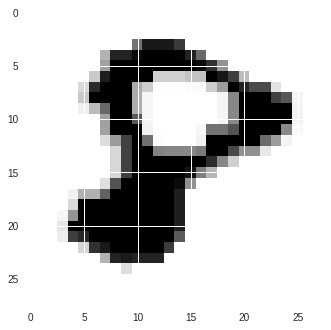

8


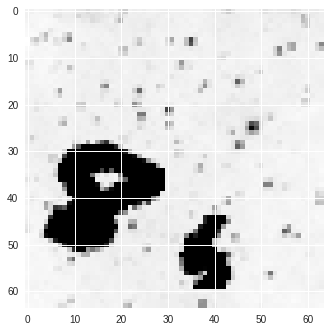

In [398]:
img_idx=300
#Testing 
print(xTrain.shape)
print(len(yTrain))
plt.imshow(xTrain[img_idx])
plt.show()
print(yTrain[img_idx])
plt.imshow(train_images[img_idx])
plt.show()


In [0]:
#Reshape for encoding.
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_valid = x_valid.reshape(x_valid.shape[0], 28, 28, 1)


#One-hot encoding
y_train = np.array(np_utils.to_categorical(y_train, number_of_classes))
y_valid = np.array(np_utils.to_categorical(y_valid, number_of_classes))


# Data augmentation

In [0]:
#Data augmentation 
datagen = ImageDataGenerator(
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        rotation_range = 16, # degree range for random rotation
        shear_range = 0.075,
        zoom_range = 0.05,
        fill_mode = 'constant',
        cval = 0)

datagen.fit(x_train)

test_gen = ImageDataGenerator()

train_generator = datagen.flow(x_train, y_train, batch_size=batch_size)
test_generator = test_gen.flow(x_valid, y_valid, batch_size=batch_size)



# Example #1 from https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

In [81]:
model = Sequential()

model = Sequential()
model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(28,28,1)))
model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

history = model.fit_generator(train_generator, epochs=2, steps_per_epoch=x_train.shape[0] // batch_size,
                              validation_data=test_generator, validation_steps=x_valid.shape[0]//batch_size)

score = model.evaluate(x_valid, y_valid)
print()
print('Validation accuracy: ', score[1])


Epoch 1/2
250/250 [==============================] - 13s 53ms/step - loss: 1.1928 - acc: 0.6151 - val_loss: 0.4512 - val_acc: 0.8863
Epoch 2/2
8000/8000 [==============================] - 1s 103us/step

Validation accuracy:  0.908875


In [0]:
print('Validation loss: ', score[0])

Validation loss:  0.2850960992276669


# Example 2

In [0]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization(axis=-1))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

# Fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))

model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

print(x_train.shape)
train_generator = gen.flow(x_train, y_train, batch_size=64)
test_generator = test_gen.flow(x_valid, y_valid, batch_size=64)

history = model.fit_generator(train_generator, steps_per_epoch=50000//64, epochs=64, 
                    validation_data=test_generator, validation_steps=10000//64)

score = model.evaluate(x_valid, y_valid)
print()
print('Validation accuracy: ', score[1])

(800, 28, 28, 1)
Epoch 1/2
781/781 [==============================] - 28s 36ms/step - loss: 0.1881 - acc: 0.9444 - val_loss: 0.5335 - val_acc: 0.8850
Epoch 2/2
200/200 [==============================] - 0s 159us/step

Validation accuracy:  0.915


# Model 3 (Parth)

In [420]:
model = Sequential()

model.add(Conv2D(filters = 20, kernel_size = (5,5), padding = 'Same', 
                 activation ='relu', input_shape = (28,28,1),                  
                  ))
#model.add(ZeroPadding2D((1,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu',
                 ))
model.add(ZeroPadding2D((1,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))


model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', 
                 activation ='relu'))
#model.add(Dropout(0.2))
model.add(Conv2D(filters = 100, kernel_size = (3,3),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))


model.add(Flatten())
#model.add(Dense(300, activation = "relu"))
#model.add(Dropout(0.5))
model.add(Dense(1000, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

# optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
optimizer='adam'

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            factor=0.5, 
                                            verbose=1,
                                            min_lr=0.00001)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_515 (Conv2D)          (None, 28, 28, 20)        520       
_________________________________________________________________
conv2d_516 (Conv2D)          (None, 28, 28, 32)        16032     
_________________________________________________________________
zero_padding2d_75 (ZeroPaddi (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_246 (MaxPoolin (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_372 (Dropout)        (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_517 (Conv2D)          (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_518 (Conv2D)          (None, 15, 15, 100)       57700     
__________

In [421]:
validation_scores = []
training_scores = []
predictions = []
for i in range (1,21):
  print()
  print()
  print("Epoch ", i*10)
  history = model.fit_generator(train_generator,
                              epochs = 10,
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              validation_data=test_generator, validation_steps=x_valid.shape[0]//batch_size
                             , callbacks=[learning_rate_reduction], verbose=0
                             )

  score = model.evaluate(x_valid, y_valid)
  print('Validation accuracy: ', score[1])
  validation_scores.append(score[1])
  
  print()
  score = model.evaluate(x_train, y_train)
  print('Training accuracy: ', score[1])
  training_scores.append(score[1])

  
  y_test=model.predict(x_test_r)
  predictions.append(y_test)






Epoch  10
8000/8000 [==============================] - 2s 265us/step
Validation accuracy:  0.950375

32000/32000 [==============================] - 9s 290us/step
Training accuracy:  0.95565625


Epoch  20

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
8000/8000 [==============================] - 2s 263us/step
Validation accuracy:  0.95575

32000/32000 [==============================] - 9s 286us/step
Training accuracy:  0.9668125


Epoch  30

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
8000/8000 [==============================] - 2s 267us/step
Validation accuracy:  0.95925

32000/32000 [==============================] - 9s 292us/step
Training accuracy:  0.97178125


Epoch  40

Epoch 00010: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
8000/8000 [==============================] - 2s 263us/step
Validation accuracy:  0.

KeyboardInterrupt: ignored

In [422]:
enum = [x*10 for x in range(1,16)]
print("Epochs", enum)
print("Validation accuracy",validation_scores)
print("Training accuracy",training_scores)



Epochs [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]
Validation accuracy [0.950375, 0.95575, 0.95925, 0.9595, 0.959625, 0.96, 0.9605, 0.95975, 0.960375, 0.96, 0.96025, 0.9605, 0.959875, 0.960625, 0.960375]
Training accuracy [0.95565625, 0.9668125, 0.97178125, 0.974125, 0.97534375, 0.9758125, 0.97590625, 0.97603125, 0.976125, 0.97615625, 0.9764375, 0.9764375, 0.9763125, 0.9766875, 0.9765625]


In [425]:
y_test=predictions[6]
y_pred = np.argmax(y_test, axis=1)
y_pred

array([7, 1, 6, ..., 7, 7, 9])

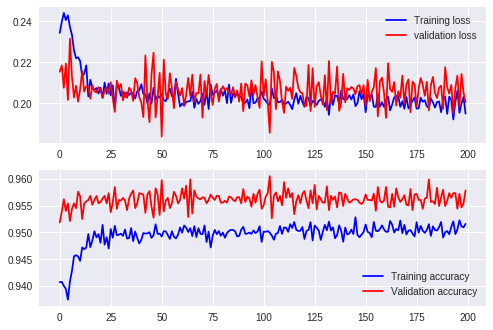

In [196]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


# Model 4


In [0]:
initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

model = Sequential()
model.add(Conv2D(filters = 10, kernel_size = (5,5),
                 activation ='relu', input_shape = (28,28,1), 
                 kernel_initializer='random_normal',
                 bias_initializer='zeros',
                 kernel_regularizer=regularizers.l2(0.01)
                ))
model.add(Conv2D(filters = 50, kernel_size = (5,5),
                 activation ='relu', 
                 kernel_initializer='random_normal',
                 bias_initializer='zeros',
                 kernel_regularizer=regularizers.l2(0.01)
                ))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(100, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

optimizer='adam'

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])


In [148]:
history = model.fit_generator(train_generator,
                              epochs = 2,
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              validation_data=test_generator, 
                              validation_steps=x_valid.shape[0]//batch_size
                              )

score = model.evaluate(x_valid, y_valid)
print()
print('Validation accuracy: ', score[1])

Epoch 1/2
250/250 [==============================] - 15s 59ms/step - loss: 1.4357 - acc: 0.5713 - val_loss: 0.5947 - val_acc: 0.8720
Epoch 2/2
8000/8000 [==============================] - 1s 114us/step

Validation accuracy:  0.888875


# Write test set results

In [353]:
x_test = preprocess(test_images, 28)
x_test_r = x_test.reshape(x_test.shape[0], 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Currently on example #:  0
Currently on example #:  2000
Currently on example #:  4000
Currently on example #:  6000
Currently on example #:  8000


In [0]:
y_test=model.predict(x_test_r)
y_pred = np.argmax(y_test, axis=1)


In [0]:
with open("submission.csv", "w+") as f:
  f.write("Id,Category\n")
  for i in range(y_pred.shape[0]):
    s = "" + str(i) + ',' + str(int(y_pred[i])) + "\n"
    f.write(s)

In [0]:
files.download("submission.csv")

Image  8954
Label 3


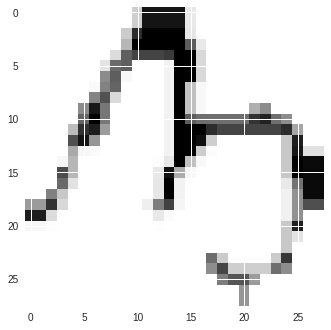

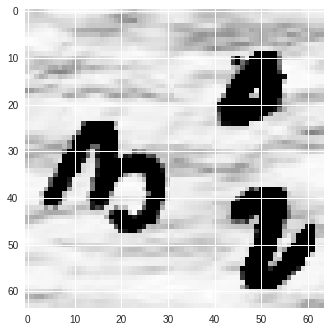

Image  6937
Label 1


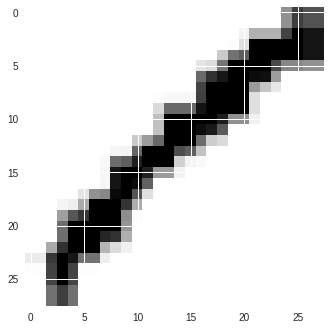

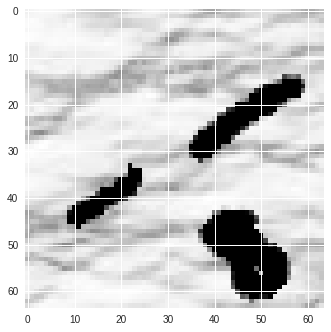

Image  3980
Label 5


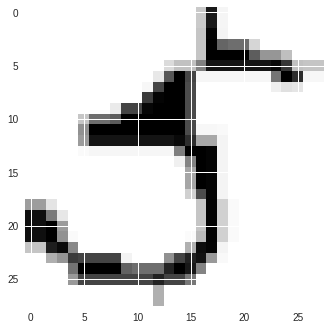

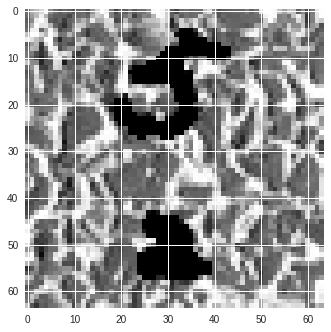

Image  5576
Label 0


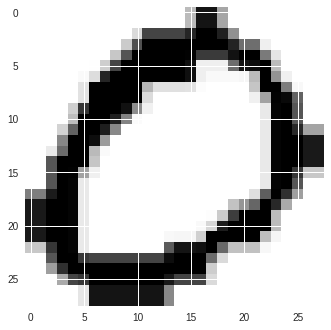

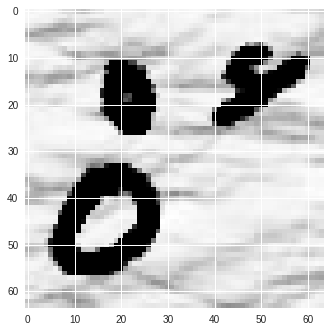

Image  6657
Label 0


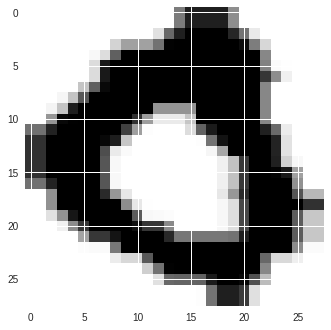

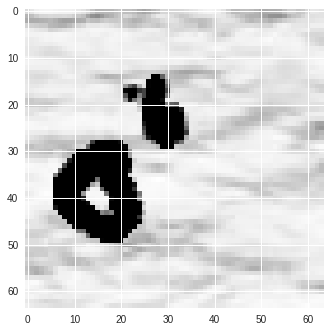

Image  7045
Label 6


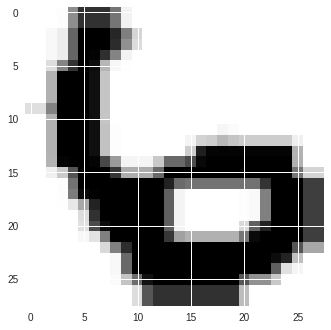

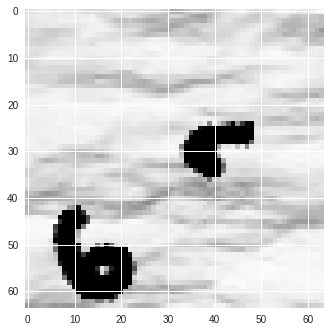

Image  6901
Label 0


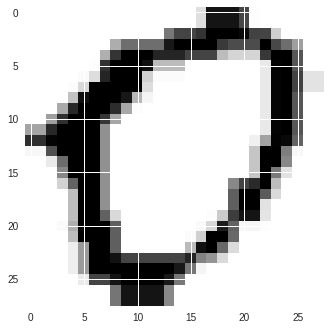

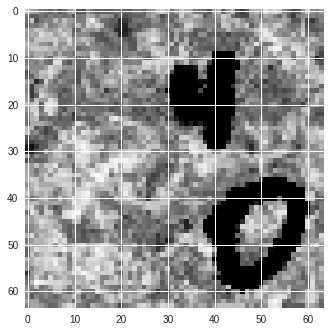

Image  7007
Label 2


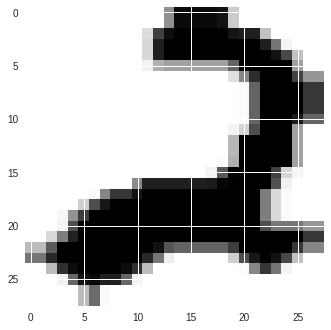

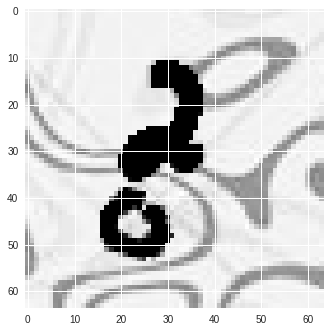

Image  9115
Label 0


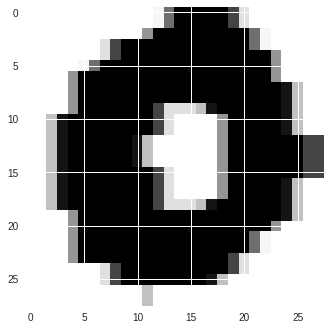

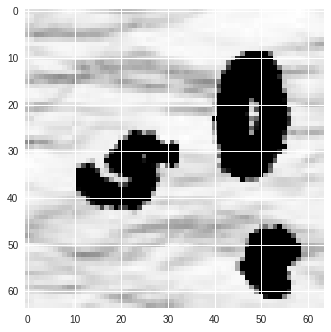

Image  3955
Label 7


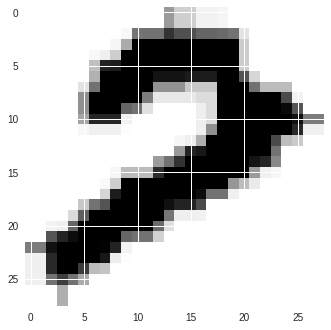

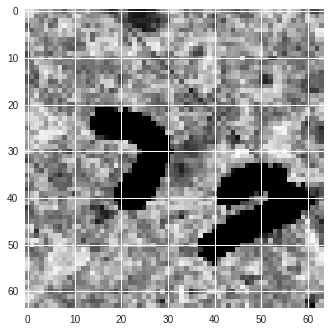

In [192]:
import random
#Checking the test predictions 
for i in range (10):
  idx = random.randint(0, y_test.shape[0])
  print ("Image ", idx)
  print ("Label", y_pred[idx])

  plt.imshow(x_test[idx])
  plt.show()
  plt.imshow(test_images[idx])
  plt.show()
